In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/MyDrive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# READ IN ALL DATA
ticker = 'FB'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,0.0,0.0,0.0,0.000000,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,0.0,1.0,1.0,99.990001,0,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,2.0,0.0,2.0,0.000000,0,2.0,1.0,100.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.000000,0,2.0,1.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.603175,0,-0.505548
4,2021-01-05,0.0,0.0,0.0,0.000000,0,0.0,0.0,-100.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.481569,1,-0.730706


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     262 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', '5Dir', '7D%Change', '6Dir', '3Dir', '6D%Change', 'High', '3D%Change', '5D%Change', 'SD_log', 'Dir', '7Dir', '2D%Change', 'Open', '4D%Change', 'Daily%Change', 'Low', '4Dir', 'SD', 'Volume']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7Dir(t-1),2D%Change(t-1),Open(t-1),4D%Change(t-1),Daily%Change(t-1),Low(t-1),4Dir(t-1),SD(t-1),Volume(t-1),Close(t-1)
9,251.360001,4,3.0,4.0,7.0,57.142041,6.0,3.0,200.000000,4.0,...,0.0,-2.170535,253.399994,-8.195989,-2.384359,244.610001,0.0,0.432037,29739400.0,245.639999
11,267.480011,2,5.0,1.0,6.0,16.666389,8.0,4.0,66.666667,1.0,...,0.0,6.293766,256.899994,3.986622,3.874923,252.720001,1.0,0.467176,28028500.0,261.100006
12,272.869995,3,3.0,2.0,5.0,39.999200,8.0,4.0,0.000000,3.0,...,0.0,6.413117,268.929993,6.294711,2.443510,263.600006,1.0,0.759440,25199900.0,267.480011
13,274.500000,4,5.0,1.0,6.0,16.666389,8.0,4.0,0.000000,3.0,...,1.0,4.507847,269.260010,11.085326,2.015098,267.489990,1.0,0.616009,20838700.0,272.869995
19,262.010010,0,13.0,4.0,17.0,23.529273,41.0,20.5,30.000000,15.0,...,0.0,-5.074604,265.299988,-7.078890,-2.516986,254.850006,0.0,0.972344,30389500.0,258.329987


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7Dir(t-1),2D%Change(t-1),Open(t-1),4D%Change(t-1),Daily%Change(t-1),Low(t-1),4Dir(t-1),SD(t-1),Volume(t-1),Close(t-1)
201,340.779999,2,9.0,1.0,10.0,9.999900,9.0,4.5,200.000000,1.0,...,1.0,4.689611,339.649994,4.760578,1.386651,337.279999,1.0,0.479750,18786300.0,339.989990
208,323.570007,4,6.0,4.0,10.0,39.999600,7.0,3.5,100.000000,4.0,...,0.0,0.351482,312.989990,-2.368988,1.505353,308.109985,0.0,1.194616,50806800.0,316.920013
209,329.980011,0,4.0,1.0,5.0,19.999600,6.0,3.0,-94.594595,2.0,...,0.0,3.635259,320.190002,-1.557697,2.098319,319.600006,0.0,0.883932,37059400.0,323.570007
210,328.079987,1,4.0,2.0,6.0,33.332778,8.0,4.0,100.000000,3.0,...,0.0,4.120913,326.040009,4.486879,1.981025,326.000000,1.0,1.153480,31518900.0,329.980011
219,347.559998,0,4.0,1.0,5.0,19.999600,6.0,3.0,100.000000,1.0,...,1.0,4.044073,330.179993,0.670374,4.012334,329.779999,1.0,1.000267,25414300.0,340.890015


In [7]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(43, 100)
(17, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(36, 7, 99) (36,)
(10, 7, 99) (10,)
1.0
0.09024948294686519


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 0.8610
Epoch 1: val_loss improved from inf to 0.43614, saving model to FB_Close_1shift_Sentiment.h5
3/3 [==============================] - 5s 595ms/step - loss: 0.8610 - val_loss: 0.4361
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.2868
Epoch 2: val_loss improved from 0.43614 to 0.09931, saving model to FB_Close_1shift_Sentiment.h5
3/3 [==============================] - 1s 238ms/step - loss: 0.2868 - val_loss: 0.0993
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.0652
Epoch 3: val_loss did not improve from 0.09931
3/3 [==============================] - 0s 161ms/step - loss: 0.0652 - val_loss: 0.1557
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.0954
Epoch 4: val_loss improved from 0.09931 to 0.02567, saving model to FB_Close_1shift_Sentiment.h5
3/3 [==============================] - 1s 256ms/step - loss: 0.0954 - val_loss: 0.0257
Epoch 5/100
3/3 [=====

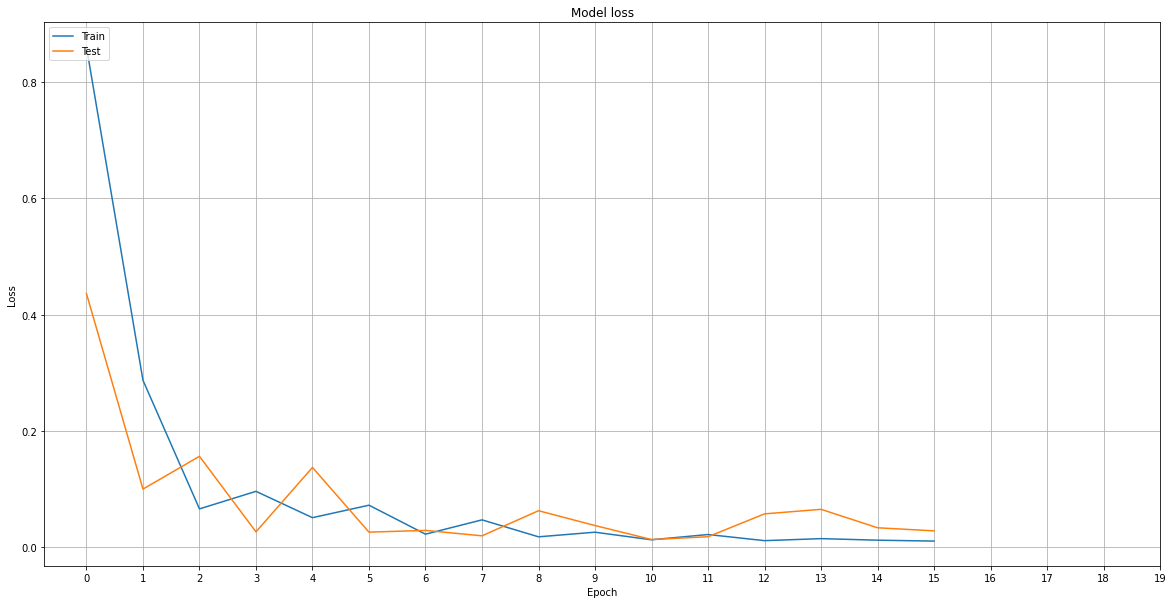

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 10.21
Mean Absolute Percentage Error (MAPE): 3.03 %
Median Absolute Percentage Error (MDAPE): 1.9 %


,MAE,MAPE,MDAPE
0,10.214795,3.029713,1.898929


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

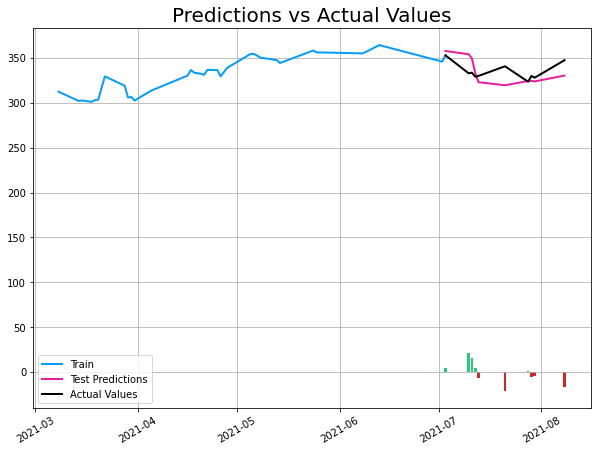

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', '5Dir', '7D%Change', '6Dir', '3Dir', '6D%Change', 'High', '3D%Change', '5D%Change', 'SD_log', 'Dir', '7Dir', '2D%Change', 'Open', '4D%Change', 'Daily%Change', 'Low', '4Dir', 'SD', 'Volume']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,7Dir(t-4),2D%Change(t-4),Open(t-4),4D%Change(t-4),Daily%Change(t-4),Low(t-4),4Dir(t-4),SD(t-4),Volume(t-4),Close(t-4)
10,261.100006,1,11.0,3.0,14.0,21.428418,14.0,7.0,266.666667,7.0,...,0.0,-6.159140,256.630005,-4.640918,-2.238748,250.300003,0.0,0.612992,26383500.0,251.089996
11,267.480011,2,11.0,3.0,14.0,21.428418,22.0,11.0,266.666667,6.0,...,0.0,-2.024606,251.550003,-6.363024,0.219046,249.199997,0.0,0.332277,19528900.0,251.639999
14,278.010010,0,5.0,1.0,6.0,16.666389,8.0,4.0,0.000000,3.0,...,0.0,6.293766,256.899994,3.986622,3.874923,252.720001,1.0,0.467176,28028500.0,261.100006
15,282.049988,1,54.0,41.0,95.0,43.157849,59.0,29.5,1700.000000,42.0,...,0.0,6.413117,268.929993,6.294711,2.443510,263.600006,1.0,0.759440,25199900.0,267.480011
20,267.079987,1,10.0,3.0,13.0,23.076746,20.0,10.0,150.000000,3.0,...,1.0,-2.111433,282.529999,-0.267520,-3.513552,268.119995,0.0,1.056203,35346200.0,272.140015


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,7Dir(t-4),2D%Change(t-4),Open(t-4),4D%Change(t-4),Daily%Change(t-4),Low(t-4),4Dir(t-4),SD(t-4),Volume(t-4),Close(t-4)
210,328.079987,1,74.0,5.0,79.0,6.329106,80.0,40.0,7300.000000,9.0,...,0.0,-5.010801,314.190002,-8.675560,-1.136758,312.059998,0.0,0.272926,29971800.0,312.220001
211,331.619995,2,2.0,1.0,3.0,33.332222,76.0,38.0,-66.666667,6.0,...,0.0,0.351482,312.989990,-2.368988,1.505353,308.109985,0.0,1.194616,50806800.0,316.920013
212,335.850006,3,4.0,1.0,5.0,19.999600,6.0,3.0,-94.594595,2.0,...,0.0,3.635259,320.190002,-1.557697,2.098319,319.600006,0.0,0.883932,37059400.0,323.570007
213,341.130005,4,4.0,2.0,6.0,33.332778,8.0,4.0,100.000000,3.0,...,0.0,4.120913,326.040009,4.486879,1.981025,326.000000,1.0,1.153480,31518900.0,329.980011
222,338.690002,3,4.0,1.0,5.0,19.999600,6.0,3.0,100.000000,1.0,...,1.0,4.044073,330.179993,0.670374,4.012334,329.779999,1.0,1.000267,25414300.0,340.890015


In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(40, 100)
(17, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(33, 7, 99) (33,)
(10, 7, 99) (10,)
1.0
0.12100706348878498


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.1787
Epoch 1: val_loss improved from inf to 0.81044, saving model to FB_Close_4shift_Sentiment.h5
3/3 [==============================] - 5s 630ms/step - loss: 2.1787 - val_loss: 0.8104
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.5326
Epoch 2: val_loss improved from 0.81044 to 0.21413, saving model to FB_Close_4shift_Sentiment.h5
3/3 [==============================] - 1s 215ms/step - loss: 0.5326 - val_loss: 0.2141
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.0737
Epoch 3: val_loss improved from 0.21413 to 0.05795, saving model to FB_Close_4shift_Sentiment.h5
3/3 [==============================] - 1s 224ms/step - loss: 0.0737 - val_loss: 0.0579
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.1899
Epoch 4: val_loss did not improve from 0.05795
3/3 [==============================] - 0s 125ms/step - loss: 0.1899 - val_loss: 0.1234
Epoch 5/100
3/3 [=====

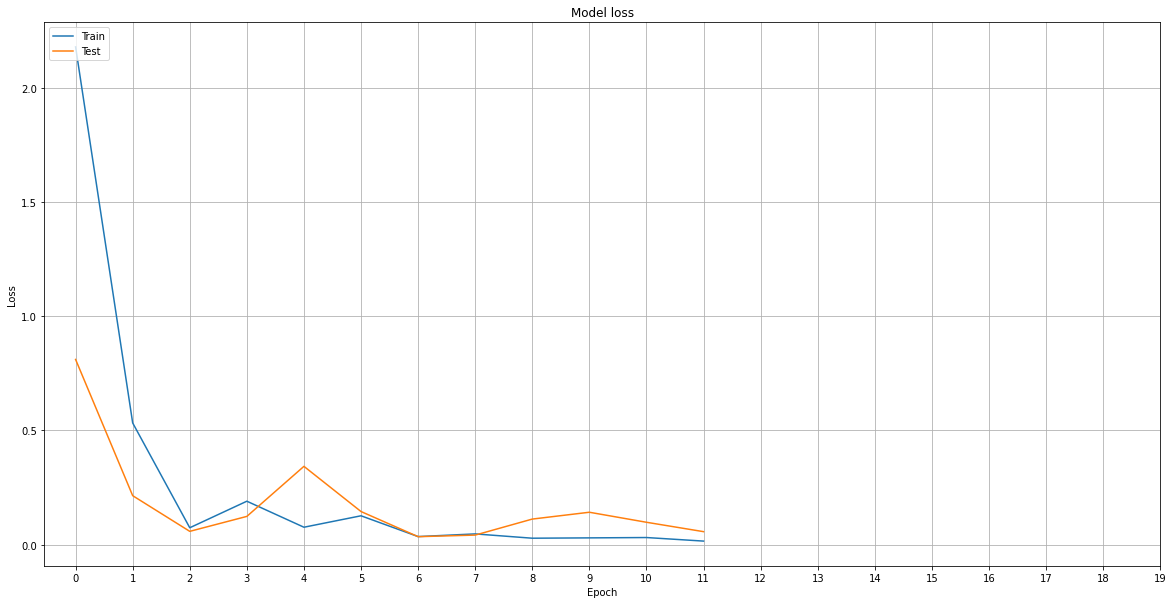

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 17.89
Mean Absolute Percentage Error (MAPE): 5.25 %
Median Absolute Percentage Error (MDAPE): 5.42 %


,MAE,MAPE,MDAPE
0,17.893307,5.25062,5.424981


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

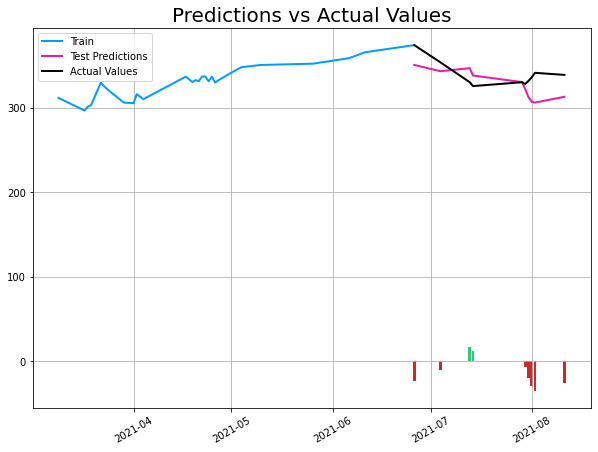

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [25]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', '5Dir', '7D%Change', '6Dir', '3Dir', '6D%Change', 'High', '3D%Change', '5D%Change', 'SD_log', 'Dir', '7Dir', '2D%Change', 'Open', '4D%Change', 'Daily%Change', 'Low', '4Dir', 'SD', 'Volume']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,7Dir(t-7),2D%Change(t-7),Open(t-7),4D%Change(t-7),Daily%Change(t-7),Low(t-7),4Dir(t-7),SD(t-7),Volume(t-7),Close(t-7)
13,274.500000,4,11.0,3.0,14.0,21.428418,14.0,7.0,266.666667,7.0,...,0.0,-6.159140,256.630005,-4.640918,-2.238748,250.300003,0.0,0.612992,26383500.0,251.089996
15,282.049988,1,5.0,1.0,6.0,16.666389,8.0,4.0,66.666667,1.0,...,0.0,-2.170535,253.399994,-8.195989,-2.384359,244.610001,0.0,0.432037,29739400.0,245.639999
16,272.140015,2,3.0,2.0,5.0,39.999200,8.0,4.0,0.000000,3.0,...,0.0,-0.111270,247.899994,-2.133622,2.328611,247.160004,0.0,0.880016,24942900.0,251.360001
17,265.000000,3,5.0,1.0,6.0,16.666389,8.0,4.0,0.000000,3.0,...,0.0,6.293766,256.899994,3.986622,3.874923,252.720001,1.0,0.467176,28028500.0,261.100006
18,258.329987,4,54.0,41.0,95.0,43.157849,59.0,29.5,1700.000000,42.0,...,0.0,6.413117,268.929993,6.294711,2.443510,263.600006,1.0,0.759440,25199900.0,267.480011


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,7Dir(t-7),2D%Change(t-7),Open(t-7),4D%Change(t-7),Daily%Change(t-7),Low(t-7),4Dir(t-7),SD(t-7),Volume(t-7),Close(t-7)
197,328.529999,3,9.0,5.0,14.0,35.714031,118.0,59.0,-96.25,24.0,...,0.0,-2.929949,328.579987,-1.958127,2.062956,326.160004,0.0,0.527391,35377900.0,332.959991
205,315.809998,1,9.0,1.0,10.0,9.999900,9.0,4.5,200.00,1.0,...,0.0,0.067789,328.679993,-0.212015,-1.147533,322.510010,0.0,0.668280,21596400.0,324.760010
212,335.850006,3,6.0,4.0,10.0,39.999600,7.0,3.5,100.00,4.0,...,0.0,-2.710942,328.260010,-7.327308,-3.918587,309.600006,0.0,1.130393,65654000.0,315.809998
213,341.130005,4,74.0,5.0,79.0,6.329106,80.0,40.0,7300.00,9.0,...,0.0,-5.010801,314.190002,-8.675560,-1.136758,312.059998,0.0,0.272926,29971800.0,312.220001
214,338.619995,0,4.0,2.0,6.0,33.332778,8.0,4.0,100.00,3.0,...,0.0,0.351482,312.989990,-2.368988,1.505353,308.109985,0.0,1.194616,50806800.0,316.920013


In [27]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(44, 100)
(17, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(37, 7, 99) (37,)
(10, 7, 99) (10,)
0.5
0.07553388994692933


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 3.2509
Epoch 1: val_loss improved from inf to 0.79183, saving model to FB_Close_7shift_Sentiment.h5
3/3 [==============================] - 4s 596ms/step - loss: 3.2509 - val_loss: 0.7918
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.5911
Epoch 2: val_loss improved from 0.79183 to 0.09228, saving model to FB_Close_7shift_Sentiment.h5
3/3 [==============================] - 1s 224ms/step - loss: 0.5911 - val_loss: 0.0923
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.0948
Epoch 3: val_loss did not improve from 0.09228
3/3 [==============================] - 1s 170ms/step - loss: 0.0948 - val_loss: 0.3119
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.1345
Epoch 4: val_loss improved from 0.09228 to 0.03964, saving model to FB_Close_7shift_Sentiment.h5
3/3 [==============================] - 1s 270ms/step - loss: 0.1345 - val_loss: 0.0396
Epoch 5/100
3/3 [=====

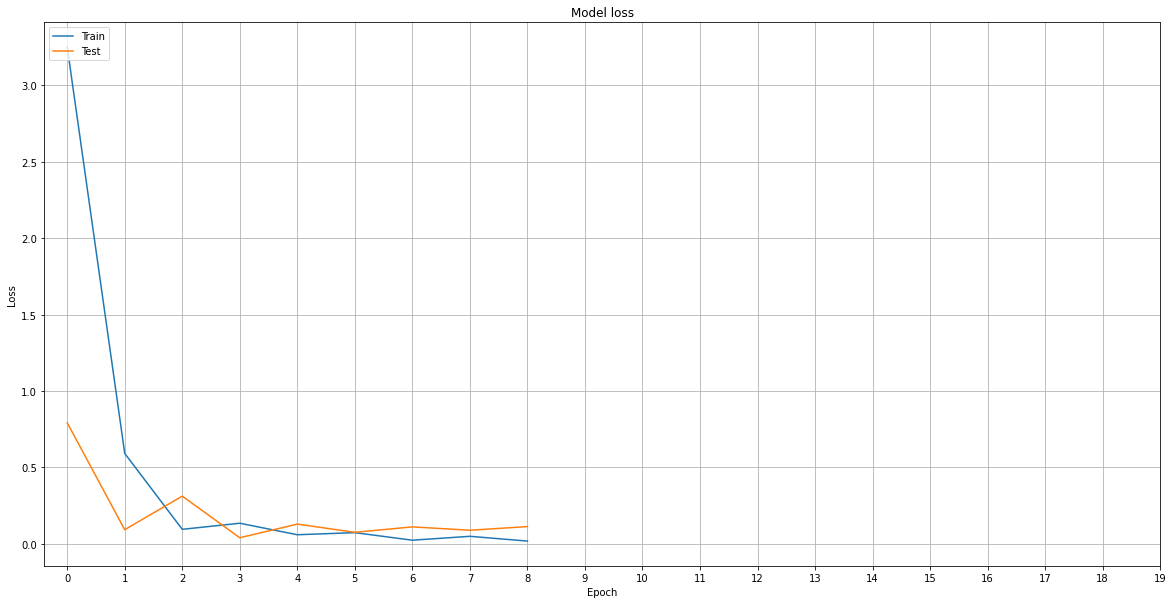

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 20.05
Mean Absolute Percentage Error (MAPE): 6.12 %
Median Absolute Percentage Error (MDAPE): 5.19 %


,MAE,MAPE,MDAPE
0,20.050552,6.120046,5.191825


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

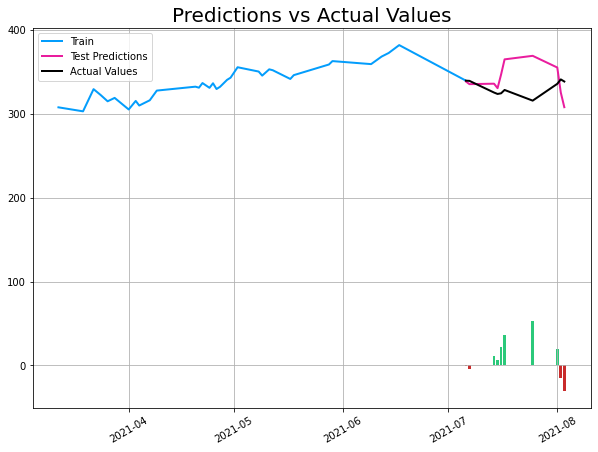

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [35]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', '5Dir', '7D%Change', '6Dir', '3Dir', '6D%Change', 'High', '3D%Change', '5D%Change', 'SD_log', 'Dir', '7Dir', '2D%Change', 'Open', '4D%Change', 'Daily%Change', 'Low', '4Dir', 'SD', 'Volume']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,7Dir(t-1),2D%Change(t-1),Open(t-1),4D%Change(t-1),Daily%Change(t-1),Low(t-1),4Dir(t-1),SD(t-1),Volume(t-1),Close(t-1)
7,251.639999,2,1.0,1.0,0.5,100.000000,1.0,0.333333,-75.000000,5.0,...,0.0,-6.159140,256.630005,-4.640918,-2.238748,250.300003,0.0,0.612992,26383500.0,251.089996
8,245.639999,3,3.0,4.0,2.0,100.000000,4.0,1.333333,100.000000,4.0,...,0.0,-2.024606,251.550003,-6.363024,0.219046,249.199997,0.0,0.332277,19528900.0,251.639999
9,251.360001,4,7.0,10.0,5.0,600.000000,11.0,3.666667,100.000000,11.0,...,0.0,-2.170535,253.399994,-8.195989,-2.384359,244.610001,0.0,0.432037,29739400.0,245.639999
10,261.100006,1,3.0,6.0,3.0,-78.571429,20.0,6.666667,-78.571429,34.0,...,0.0,-0.111270,247.899994,-2.133622,2.328611,247.160004,0.0,0.880016,24942900.0,251.360001
11,267.480011,2,6.0,9.0,4.5,100.000000,12.0,4.000000,-57.142857,26.0,...,0.0,6.293766,256.899994,3.986622,3.874923,252.720001,1.0,0.467176,28028500.0,261.100006


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()


FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'comment_count_rollsum_4D(t-1)', 'comment_count_rollmean_4D(t-1)', 'comment_count_4D_pctchg(t-1)', 'comment_count_rollsum_5D(t-1)', 'comment_count_rollmean_5D(t-1)', 'comment_count_5D_pctchg(t-1)', 'comment_count_rollsum_6D(t-1)', 'comment_count_rollmean_6D(t-1)', 'comment_count_6D_pctchg(t-1)', 'comment_count_rollsum_7D(t-1)', 'comment_count_rollmean_7D(t-1)', 'comment_count_7D_pctchg(t-1)', 'is_meme(t-1)', '2Dir(t-1)', '5Dir(t-1)', '7D%Change(t-1)', '6Dir(t-1)', '3Dir(t-1)', '6D%Change(t-1)', 'High(t-1)', '3D%Change(t-1)', '5D%Change(t-1)', 'SD_log(t-1)', 'Dir(t-1)', '7Dir(t-1)', '2D%Change(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Daily%Change(t-1)', 'Low(t-1)', '4Dir(t-1)', 'SD(t-1)', 'Volume(t-1)', 'Close(t-1)']


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,7Dir(t-1),2D%Change(t-1),Open(t-1),4D%Change(t-1),Daily%Change(t-1),Low(t-1),4Dir(t-1),SD(t-1),Volume(t-1),Close(t-1)
218,340.890015,4,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,3.0,...,0.0,-2.275101,329.820007,-3.925194,0.030514,327.000000,0.0,0.356460,12376600.0,327.739990
219,347.559998,0,5.0,7.0,3.5,100.0,7.0,2.333333,150.0,9.0,...,1.0,4.044073,330.179993,0.670374,4.012334,329.779999,1.0,1.000267,25414300.0,340.890015
220,342.959991,1,1.0,6.0,3.0,-50.0,8.0,2.666667,100.0,8.0,...,1.0,6.047479,344.339996,3.634792,1.956638,343.200012,1.0,1.102479,25076600.0,347.559998
229,324.459991,1,3.0,3.0,1.5,100.0,3.0,1.000000,100.0,3.0,...,0.0,-0.888406,336.890015,-0.873878,1.473944,335.309998,0.0,0.542022,16650900.0,338.029999
237,329.750000,4,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,1.0,2.171559,329.540009,7.489249,-0.223860,328.000000,1.0,0.517367,16879200.0,329.820007


In [37]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(121, 43)
(37, 43)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(114, 7, 42) (114,)
(30, 7, 42) (30,)
0.0
0.2370734727380719


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 0.1642
Epoch 1: val_loss improved from inf to 0.03044, saving model to FB_Close_1shift_Baseline.h5
8/8 [==============================] - 4s 151ms/step - loss: 0.1616 - val_loss: 0.0304
Epoch 2/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0260
Epoch 2: val_loss improved from 0.03044 to 0.02938, saving model to FB_Close_1shift_Baseline.h5
8/8 [==============================] - 0s 50ms/step - loss: 0.0259 - val_loss: 0.0294
Epoch 3/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0211
Epoch 3: val_loss improved from 0.02938 to 0.02316, saving model to FB_Close_1shift_Baseline.h5
8/8 [==============================] - 0s 50ms/step - loss: 0.0214 - val_loss: 0.0232
Epoch 4/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0111
Epoch 4: val_loss improved from 0.02316 to 0.01089, saving model to FB_Close_1shift_Baseline.h5
8/8 [==============================] - 0s 50ms/step - loss: 0.010

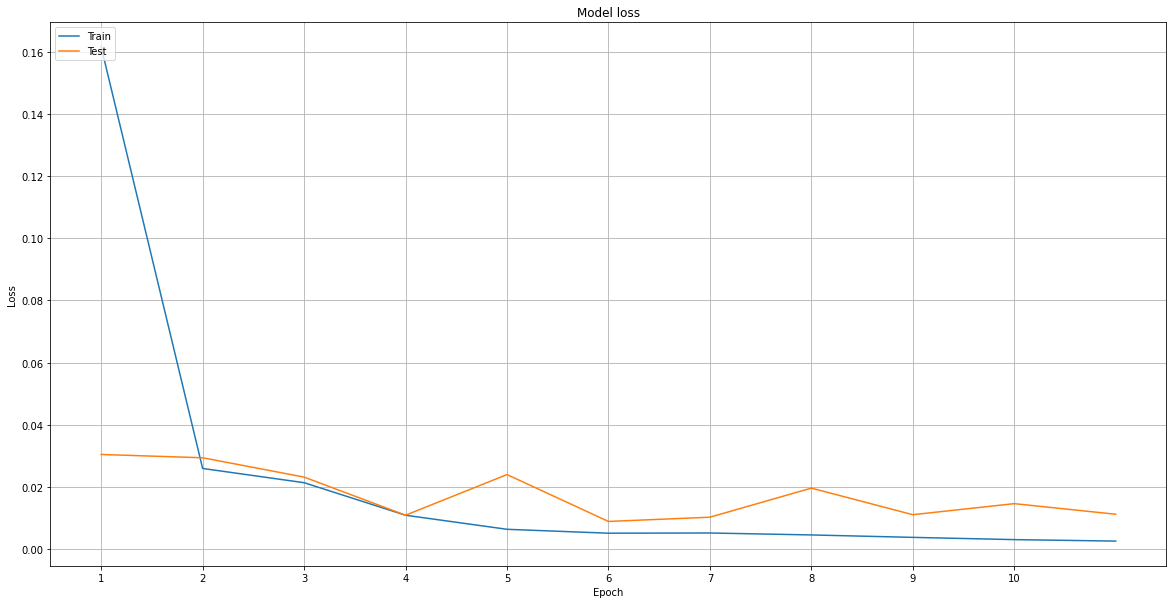

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 10.92
Mean Absolute Percentage Error (MAPE): 3.28 %
Median Absolute Percentage Error (MDAPE): 3.13 %


,MAE,MAPE,MDAPE
0,10.922646,3.282811,3.125967


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

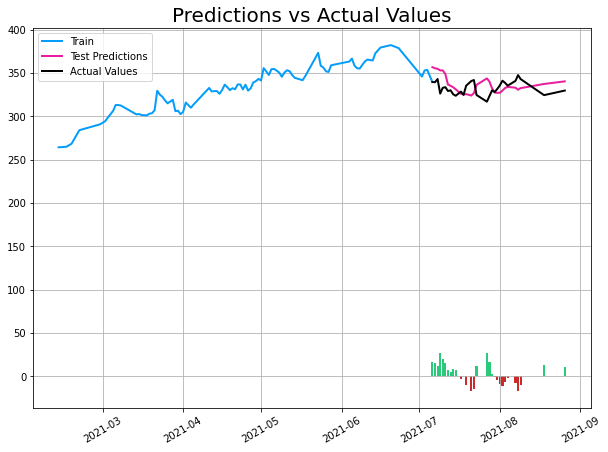

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [45]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', '5Dir', '7D%Change', '6Dir', '3Dir', '6D%Change', 'High', '3D%Change', '5D%Change', 'SD_log', 'Dir', '7Dir', '2D%Change', 'Open', '4D%Change', 'Daily%Change', 'Low', '4Dir', 'SD', 'Volume']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,7Dir(t-4),2D%Change(t-4),Open(t-4),4D%Change(t-4),Daily%Change(t-4),Low(t-4),4Dir(t-4),SD(t-4),Volume(t-4),Close(t-4)
10,261.100006,1,14.0,21.0,10.5,366.666667,24.0,8.000000,1300.000000,25.0,...,0.0,-6.159140,256.630005,-4.640918,-2.238748,250.300003,0.0,0.612992,26383500.0,251.089996
11,267.480011,2,14.0,28.0,14.0,100.000000,35.0,11.666667,366.666667,38.0,...,0.0,-2.024606,251.550003,-6.363024,0.219046,249.199997,0.0,0.332277,19528900.0,251.639999
12,272.869995,3,3.0,17.0,8.5,-78.571429,31.0,10.333333,-57.142857,38.0,...,0.0,-2.170535,253.399994,-8.195989,-2.384359,244.610001,0.0,0.432037,29739400.0,245.639999
13,274.500000,4,3.0,6.0,3.0,-78.571429,20.0,6.666667,-78.571429,34.0,...,0.0,-0.111270,247.899994,-2.133622,2.328611,247.160004,0.0,0.880016,24942900.0,251.360001
14,278.010010,0,6.0,11.0,5.5,0.000000,17.0,5.666667,100.000000,20.0,...,0.0,6.293766,256.899994,3.986622,3.874923,252.720001,1.0,0.467176,28028500.0,261.100006


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'comment_count_rollsum_4D(t-4)', 'comment_count_rollmean_4D(t-4)', 'comment_count_4D_pctchg(t-4)', 'comment_count_rollsum_5D(t-4)', 'comment_count_rollmean_5D(t-4)', 'comment_count_5D_pctchg(t-4)', 'comment_count_rollsum_6D(t-4)', 'comment_count_rollmean_6D(t-4)', 'comment_count_6D_pctchg(t-4)', 'comment_count_rollsum_7D(t-4)', 'comment_count_rollmean_7D(t-4)', 'comment_count_7D_pctchg(t-4)', 'is_meme(t-4)', '2Dir(t-4)', '5Dir(t-4)', '7D%Change(t-4)', '6Dir(t-4)', '3Dir(t-4)', '6D%Change(t-4)', 'High(t-4)', '3D%Change(t-4)', '5D%Change(t-4)', 'SD_log(t-4)', 'Dir(t-4)', '7Dir(t-4)', '2D%Change(t-4)', 'Open(t-4)', '4D%Change(t-4)', 'Daily%Change(t-4)', 'Low(t-4)', '4Dir(t-4)', 'SD(t-4)', 'Volume(t-4)', 'Close(t-4)']


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,7Dir(t-4),2D%Change(t-4),Open(t-4),4D%Change(t-4),Daily%Change(t-4),Low(t-4),4Dir(t-4),SD(t-4),Volume(t-4),Close(t-4)
225,337.250000,1,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,1.0,-1.953622,344.239990,3.975712,-0.638559,340.100006,1.0,0.309092,13602800.0,340.769989
232,306.839996,4,3.0,3.0,1.5,100.0,3.0,1.000000,100.0,3.0,...,0.0,-0.888406,336.890015,-0.873878,1.473944,335.309998,0.0,0.542022,16650900.0,338.029999
234,322.809998,1,5.0,5.0,2.5,100.0,5.0,1.666667,100.0,5.0,...,0.0,-8.114662,330.290009,-8.930977,-4.271709,310.290009,0.0,0.735966,30329600.0,310.600006
235,330.559998,2,1.0,6.0,3.0,100.0,6.0,2.000000,100.0,6.0,...,0.0,-4.336429,311.399994,-6.823361,-0.067608,307.200012,0.0,0.450707,24396200.0,310.390015
238,334.489990,0,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,0.0,5.204667,321.570007,3.931098,1.554095,321.000000,1.0,0.794797,18794000.0,322.809998


In [47]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(121, 43)
(37, 43)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(114, 7, 42) (114,)
(30, 7, 42) (30,)
0.75
0.08184486352850273


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 0.1834
Epoch 1: val_loss improved from inf to 0.01292, saving model to FB_Close_4shift_Baseline.h5
8/8 [==============================] - 5s 167ms/step - loss: 0.1813 - val_loss: 0.0129
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.0295
Epoch 2: val_loss did not improve from 0.01292
8/8 [==============================] - 0s 44ms/step - loss: 0.0295 - val_loss: 0.0321
Epoch 3/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0223
Epoch 3: val_loss did not improve from 0.01292
8/8 [==============================] - 0s 41ms/step - loss: 0.0224 - val_loss: 0.0245
Epoch 4/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0126
Epoch 4: val_loss did not improve from 0.01292
8/8 [==============================] - 0s 40ms/step - loss: 0.0125 - val_loss: 0.0303
Epoch 5/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 5: val_loss did not improve from 0.01292
8/8 [

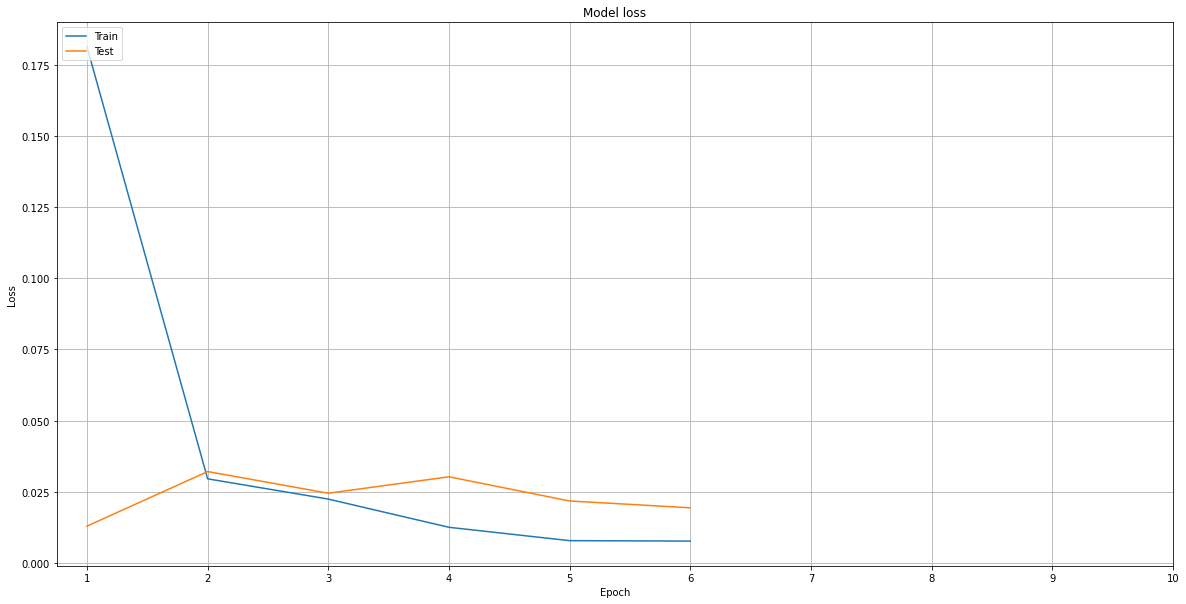

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 11.62
Mean Absolute Percentage Error (MAPE): 3.52 %
Median Absolute Percentage Error (MDAPE): 3.24 %


,MAE,MAPE,MDAPE
0,11.622064,3.521555,3.237009


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

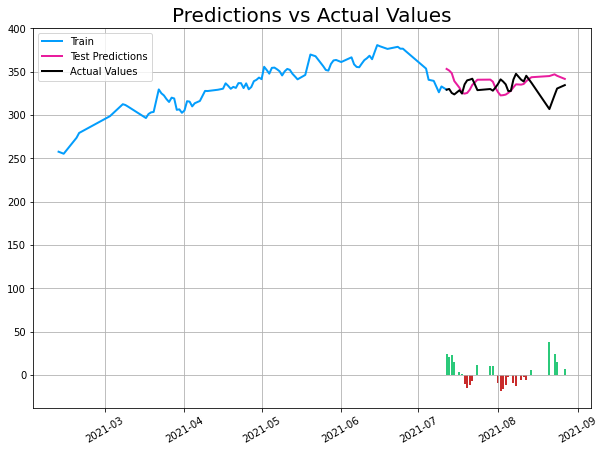

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [55]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', '5Dir', '7D%Change', '6Dir', '3Dir', '6D%Change', 'High', '3D%Change', '5D%Change', 'SD_log', 'Dir', '7Dir', '2D%Change', 'Open', '4D%Change', 'Daily%Change', 'Low', '4Dir', 'SD', 'Volume']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,7Dir(t-7),2D%Change(t-7),Open(t-7),4D%Change(t-7),Daily%Change(t-7),Low(t-7),4Dir(t-7),SD(t-7),Volume(t-7),Close(t-7)
13,274.500000,4,14.0,21.0,10.5,366.666667,24.0,8.000000,1300.000000,25.0,...,0.0,-6.159140,256.630005,-4.640918,-2.238748,250.300003,0.0,0.612992,26383500.0,251.089996
14,278.010010,0,3.0,6.0,3.0,-78.571429,20.0,6.666667,-78.571429,34.0,...,0.0,-2.024606,251.550003,-6.363024,0.219046,249.199997,0.0,0.332277,19528900.0,251.639999
15,282.049988,1,6.0,9.0,4.5,100.000000,12.0,4.000000,-57.142857,26.0,...,0.0,-2.170535,253.399994,-8.195989,-2.384359,244.610001,0.0,0.432037,29739400.0,245.639999
16,272.140015,2,5.0,11.0,5.5,66.666667,14.0,4.666667,66.666667,17.0,...,0.0,-0.111270,247.899994,-2.133622,2.328611,247.160004,0.0,0.880016,24942900.0,251.360001
17,265.000000,3,6.0,11.0,5.5,0.000000,17.0,5.666667,100.000000,20.0,...,0.0,6.293766,256.899994,3.986622,3.874923,252.720001,1.0,0.467176,28028500.0,261.100006


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'comment_count_rollsum_4D(t-7)', 'comment_count_rollmean_4D(t-7)', 'comment_count_4D_pctchg(t-7)', 'comment_count_rollsum_5D(t-7)', 'comment_count_rollmean_5D(t-7)', 'comment_count_5D_pctchg(t-7)', 'comment_count_rollsum_6D(t-7)', 'comment_count_rollmean_6D(t-7)', 'comment_count_6D_pctchg(t-7)', 'comment_count_rollsum_7D(t-7)', 'comment_count_rollmean_7D(t-7)', 'comment_count_7D_pctchg(t-7)', 'is_meme(t-7)', '2Dir(t-7)', '5Dir(t-7)', '7D%Change(t-7)', '6Dir(t-7)', '3Dir(t-7)', '6D%Change(t-7)', 'High(t-7)', '3D%Change(t-7)', '5D%Change(t-7)', 'SD_log(t-7)', 'Dir(t-7)', '7Dir(t-7)', '2D%Change(t-7)', 'Open(t-7)', '4D%Change(t-7)', 'Daily%Change(t-7)', 'Low(t-7)', '4Dir(t-7)', 'SD(t-7)', 'Volume(t-7)', 'Close(t-7)']


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,7Dir(t-7),2D%Change(t-7),Open(t-7),4D%Change(t-7),Daily%Change(t-7),Low(t-7),4Dir(t-7),SD(t-7),Volume(t-7),Close(t-7)
227,333.119995,4,1.0,1.0,0.5,100.0,1.0,0.333333,100.0,1.0,...,1.0,0.607227,343.829987,4.675856,-1.323514,340.869995,1.0,0.819187,18181100.0,342.959991
230,310.600006,2,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,1.0,1.329342,342.200012,-0.650250,1.951633,339.899994,0.0,1.135050,26488500.0,345.299988
233,317.869995,0,3.0,3.0,1.5,100.0,3.0,1.000000,100.0,3.0,...,0.0,0.014659,336.000000,0.699753,1.129725,332.809998,1.0,0.434044,13566200.0,341.059998
237,329.750000,4,5.0,5.0,2.5,100.0,5.0,1.666667,100.0,5.0,...,0.0,-8.114662,330.290009,-8.930977,-4.271709,310.290009,0.0,0.735966,30329600.0,310.600006
241,334.899994,3,2.0,2.0,1.0,100.0,2.0,0.666667,100.0,2.0,...,0.0,5.204667,321.570007,3.931098,1.554095,321.000000,1.0,0.794797,18794000.0,322.809998


In [57]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(127, 43)
(38, 43)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


(120, 7, 42) (120,)
(31, 7, 42) (31,)
0.25
0.09728317804574371


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 0.1324
Epoch 1: val_loss improved from inf to 0.02285, saving model to FB_Close_7shift_Baseline.h5
8/8 [==============================] - 5s 158ms/step - loss: 0.1258 - val_loss: 0.0228
Epoch 2/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0279
Epoch 2: val_loss did not improve from 0.02285
8/8 [==============================] - 0s 40ms/step - loss: 0.0284 - val_loss: 0.0462
Epoch 3/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0213
Epoch 3: val_loss did not improve from 0.02285
8/8 [==============================] - 0s 39ms/step - loss: 0.0227 - val_loss: 0.0395
Epoch 4/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0115
Epoch 4: val_loss did not improve from 0.02285
8/8 [==============================] - 0s 41ms/step - loss: 0.0111 - val_loss: 0.0307
Epoch 5/100
7/8 [=========================>....] - ETA: 0s - loss: 0.0077
Epoch 5: val_loss did not improve from 0.02285
8/8 [

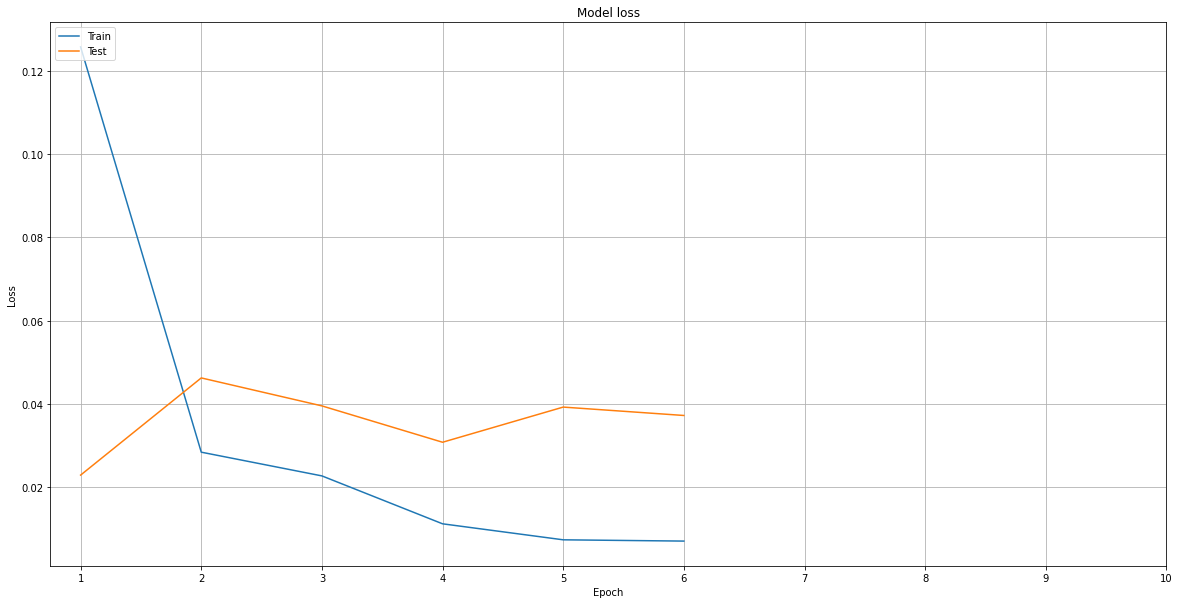

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 15.36
Mean Absolute Percentage Error (MAPE): 4.64 %
Median Absolute Percentage Error (MDAPE): 3.91 %


,MAE,MAPE,MDAPE
0,15.355543,4.635999,3.908026


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

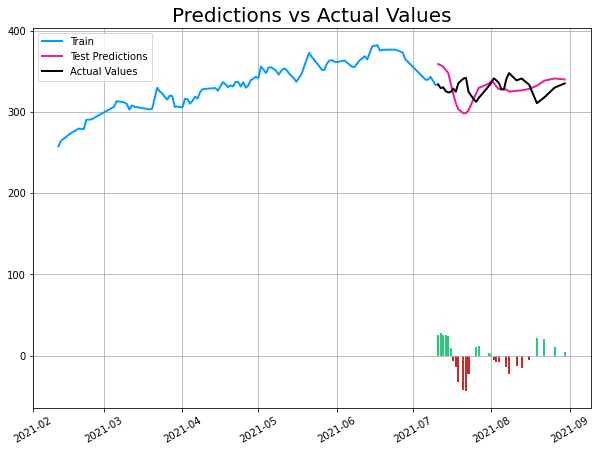

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## Overall Results

In [65]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,10.922646,10.214795
1,1dayshift,MAPE,3.282811,3.029713
2,1dayshift,MDAPE,3.125967,1.898929
3,4dayshift,MAE,11.622064,17.893307
4,4dayshift,MAPE,3.521555,5.250620
5,4dayshift,MDAPE,3.237009,5.424981
6,7dayshift,MAE,15.355543,20.050552
7,7dayshift,MAPE,4.635999,6.120046
8,7dayshift,MDAPE,3.908026,5.191825


In [66]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)